Notebook detailing the implementation of the jet core detection method originally introduced in Manney et al. 2011

## load in libraries

In [1]:
import numpy as np
import xarray as xr
import scipy.ndimage # used for labelling connected regions of windspeed above threshold
import matplotlib.pyplot as plt

import jsmetrics
from jsmetrics.utils import data_utils, spatial_utils, windspeed_utils

print("jsmetrics version", jsmetrics.__version__)
print("xarray version", xr.__version__)

jsmetrics version 0.2.0-alpha
xarray version 2023.3.0


## load in data

In [2]:
ua = xr.open_dataset('../jsmetrics-examples/data/era5_u_wind_JF21.nc')
va = xr.open_dataset('../jsmetrics-examples/data/era5_v_wind_JF21.nc')

In [3]:
## merge u and v wind components
uava = xr.merge([ua, va])

In [4]:
## this is necessary because jsmetrics currently only accept standardised names as input
uava = uava.rename({'longitude':'lon', 'latitude':'lat', 'level':'plev', 'u':'ua', 'v':'va'})


In [5]:
## calculate windspeed from u and v wind components
uava['ws'] = windspeed_utils.get_resultant_wind(uava['ua'],uava['va'])

In [6]:
## global variable for plev limit on jet core detection
jet_core_plev_limit = (100, 400)

In [7]:
jet_core_ws_threshold=40
jet_boundary_ws_threshold=30

In [8]:
## get potential regions of jet cores and regions by only selecting above thresholds 
uava['potential_jet_cores'] = uava['ws'].where(lambda val: (val>=jet_core_ws_threshold) & (val.plev >= min(jet_core_plev_limit)) & (val.plev <= max(jet_core_plev_limit)), 0)
uava['potential_jet_regions'] = uava['ws'].where(lambda val: val>=jet_boundary_ws_threshold, 0)

In [9]:
## for the example in this notebook load in only one day
ws_slice = uava.isel(time=-1).load()

### Step 1. Find local maxima within 2-d array
This is an implementation of the local maxima detection in M11 (only checks neighbours left, right, above and below)

In [10]:
def add_pad_to_array(arr, pad_width=1, constant_values=0):
    """
    Add a edge of constant values around a numpy array
    
    Parameters
    ----------
    arr : array-like
        A 2-D array with numeric values (i.e. dtypes float or int)
    pad_width : int
        Width of values to add to edges (default: 1)
    constant_values : int
        Value to add to edges (default: 0)
        
    Returns
    ----------
    padded_arr : array-like
        A 2-D array with new dimensions as a pad has been added at the edges
    """
    padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=constant_values)
    return padded_arr

    
def find_local_maxima_in_2d_dataarray(arr):
    """
    Find indices of local maximas within a 2-D array. Should return two values which relate to the position of local maximas (if any).

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011
    
    Parameters
    ----------
    arr : xr.DataArray or array-like
        A 2-D array with numeric values (i.e. dtypes float or int)
        
    Returns
    ----------
    local_maxima : xr.DataArray
        A 2-D array with values relating to the index of the local maximas
        
    Examples
    ----------
    .. code-block:: python
    
        import numpy as np
        import xarray as xr
        
        # Example array
        data = np.array([
            [1, 2, 3, 4, 5],
            [2, 3, 4, 5, 4],
            [3, 4, 5, 6, 7],
            [4, 5, 6, 7, 6],
            [5, 6, 7, 8, 9]
        ])
        
        # Convert NumPy array to xarray DataArray
        data_array = xr.DataArray(data)

        local_maxima_indices = find_local_maxima_in_2d_dataarray(data_array)

        for i, j in local_maxima_indices:
            print(f"Local maximum at ({i}, {j}): {data_array[i, j]}")
            
    """
    # Add padding to array to allow edges to be picked up
    arr = add_pad_to_array(arr)

    # Calculate neighbors for all interior points
    neighbors = np.stack([
        arr[:-2, 1:-1],  # Above
        arr[2:, 1:-1],   # Below
        arr[1:-1, :-2],  # Left
        arr[1:-1, 2:]    # Right
    ], axis=-1)
    
    # Find local maximas
    interior_maxima = (arr[1:-1, 1:-1] > np.max(neighbors, axis=-1))
    interior_indices = np.transpose(np.where(interior_maxima))
    
    return np.array(interior_indices)

In [11]:
%%time 
local_maximas_dict = {}
local_maximas_alt_dict = {}
for ind, lon in enumerate(ws_slice['potential_jet_cores']['lon']):
    wsl = ws_slice['potential_jet_cores'].sel(lon=lon)
    local_maximas = find_local_maxima_in_2d_dataarray(wsl)
    local_maximas_dict[float(lon)] = local_maximas

CPU times: user 317 ms, sys: 4.51 ms, total: 321 ms
Wall time: 319 ms


In [12]:
local_maximas_dict[0.0] # look at longitude 0.0. The returned values are indexes of plev and lat

array([[ 1, 20],
       [ 1, 66],
       [ 2, 19]])

In [13]:
## first value 1, 20 relates to 250 hPa and 70 N
float(ws_slice['plev'][local_maximas_dict[0.0][0][0]]), float(ws_slice['lat'][local_maximas_dict[0.0][0][1]])

(250.0, 70.0)

### Step 2. Create a mask of potential jet regions
These regions will later be subset if two or more occur in same region/30 ms contour

In [14]:
def create_mask_using_local_maximas(local_maximas, mask_shape):
    """
    Will create a mask with the same dimensions as the inputted mask_shape
    and only the local maxima as value 1. All other values will be 0.
    
    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------        
    local_maximas : np.array
        An array containing values relating to the index of the local maximas in a mask with shape: mask_shape
    
    mask_shape : tuple
        Values to create a mask of given shape from.
        
    Returns
    ----------
    mask : np.array
        An array with shape: mask_shape with only the indexes of the local maximas as 1 All other values will 0.
        
    """
    empty_mask = np.zeros(mask_shape)
    
    for i, j in local_maximas:
        empty_mask[i, j] = 1
    return empty_mask

In [15]:
mask_shape = ws_slice['ws'].isel(lon=0).shape

In [16]:
mask_shape # 6 plevs, 91 latitudes

(6, 91)

In [17]:
%%time
initial_jet_core_masks = np.array([])
for ind, local_maximas in enumerate(local_maximas_dict.values()):
    initial_jet_core_mask = create_mask_using_local_maximas(mask_shape=mask_shape, local_maximas=local_maximas)
    
    # Make the numpy matrix to stack onto using first longitude maximas
    if ind == 0:
        initial_jet_core_masks = initial_jet_core_mask
        continue
    
    initial_jet_core_masks = np.dstack([initial_jet_core_masks, initial_jet_core_mask])

CPU times: user 32.4 ms, sys: 2.08 ms, total: 34.5 ms
Wall time: 32.9 ms


In [18]:
initial_jet_core_masks.shape

(6, 91, 360)

In [19]:
initial_jet_core_masks.shape, ws_slice['ws'].shape

((6, 91, 360), (6, 91, 360))

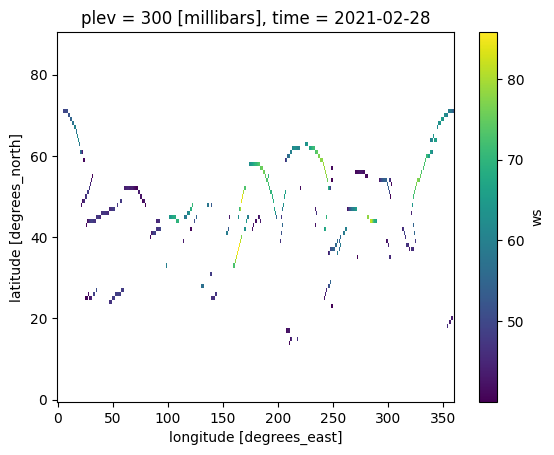

In [20]:
ws_slice.where(initial_jet_core_masks)['ws'].isel(plev=2).plot()

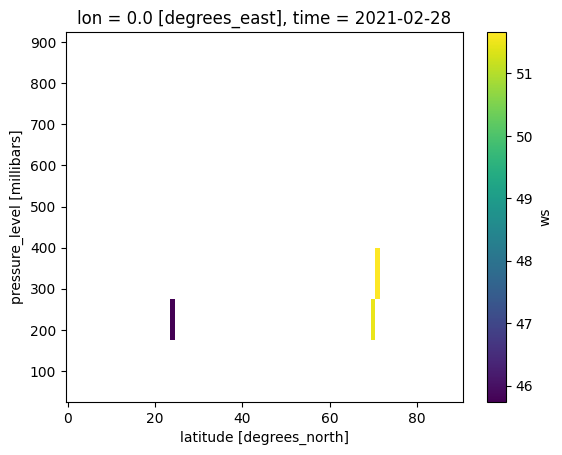

In [21]:
ws_slice.where(initial_jet_core_masks).isel(lon=0)['ws'].plot()

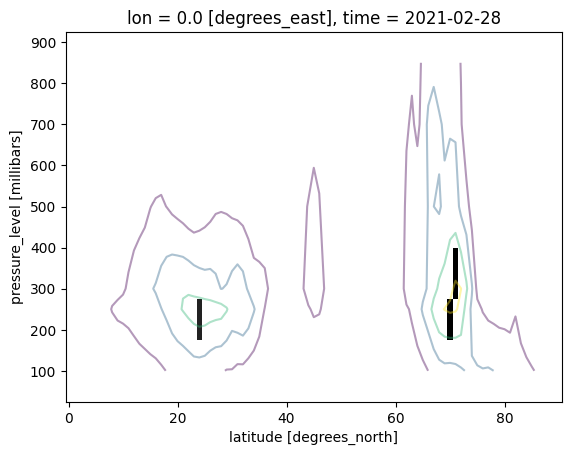

In [22]:
ws_slice['ws'].isel(lon=0).plot.contour(levels=[20, 30, 40, 50], alpha=.4)
ws_slice.where(initial_jet_core_masks).isel(lon=0)['ws'].plot(vmin=0, cmap='Greys',\
                                                              add_colorbar=False)

### Step 3. Get region contour mask to use in subsetting
The 'contour mask' is a variable that is not returned by the original method, but is also included as the user may find it useful   

In [23]:
def get_jet_region_contour_mask(potential_jet_regions, local_maximas):
    """
    Will create a mask based on regions (above ws_threshold) around the jet cores that are
    contiguous.
    The mask will contain categorical values (e.g. 1, 2) for each cluster of jet regions
    contain a jet core. All other values will be 0 (i.e not a jet core or jet region)
    
    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    potential_jet_regions : xr.DataArray
        Windspeeds of regions above the jet region threshold
        
    local_maximas : np.array
        An array containing values relating to the index of the local maximas (should be the same shape as input: potential_jet_regions)
        
    Returns
    ----------
    jet_region_contour_mask : np.array
        A 2-D array with shape: mask_shape with only the indexes of the local maximas as 1 All other values will 0.
        
    """
    potential_jet_regions_mask , _ = scipy.ndimage.label(potential_jet_regions)
    actual_jet_region_nums = get_jet_region_numbers(local_maximas, potential_jet_regions_mask)
    jet_region_contour_mask = subset_jet_region_mask_to_regions_with_cores(potential_jet_regions_mask, actual_jet_region_nums)
    
    ## Refine jet regions to new values (i.e. if labels have been removed this resets them) 
    jet_region_contour_mask, _ = scipy.ndimage.label(jet_region_contour_mask)
    return jet_region_contour_mask
    
    
def get_jet_region_numbers(local_maximas, potential_jet_regions_mask):
    """
    Will only return clusters ID numbers of jet regions with an actual jet core in them.
    
    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------        
    local_maximas : np.array
        An array containing values relating to the index of the local maximas (should be the same shape as input: potential_jet_regions)
    
    potential_jet_regions_mask : numpy.array
        Array of jet regions clusters as returned by scipy.ndimage.label
        
    Returns
    ----------
    actual_jet_region_nums : list
        A list of cluster ID numbers with local maximas in them
    
    """
    actual_jet_region_nums = []
    for i, j in local_maximas:
        valid_region = potential_jet_regions_mask[i, j]
        if not valid_region in actual_jet_region_nums:
            actual_jet_region_nums.append(valid_region)
    return actual_jet_region_nums
            
            
def subset_jet_region_mask_to_regions_with_cores(potential_jet_regions_mask, actual_jet_region_nums):
    """
    Will subset jet region mask to only those with an actual jet core in them.

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------        
    potential_jet_regions_mask : numpy.array
        Array of jet regions clusters as returned by scipy.ndimage.label
        
    actual_jet_region_nums : list
        A list of cluster ID numbers with local maximas in them
    
    Returns
    ----------
    potential_jet_regions_mask : numpy.array
        Subset version of jet regions mask containing only jet region clusters with local maxima in them 

    """
    for reg_num in np.unique(potential_jet_regions_mask):
        if not reg_num in actual_jet_region_nums:
            potential_jet_regions_mask[potential_jet_regions_mask == reg_num] = 0
    return potential_jet_regions_mask

In [24]:
%%time
for ind, lon in enumerate(ws_slice.lon):
    jet_region_contour_mask = get_jet_region_contour_mask(ws_slice['potential_jet_regions'].sel(lon=lon),\
                                                          local_maximas_dict[float(lon)])
    
    # Make the numpy matrix to stack onto using first longitude ws_contour mask
    if ind == 0:
        jet_region_contour_masks = jet_region_contour_mask
        continue
    jet_region_contour_masks = np.dstack([jet_region_contour_masks, jet_region_contour_mask])

CPU times: user 376 ms, sys: 831 µs, total: 377 ms
Wall time: 376 ms


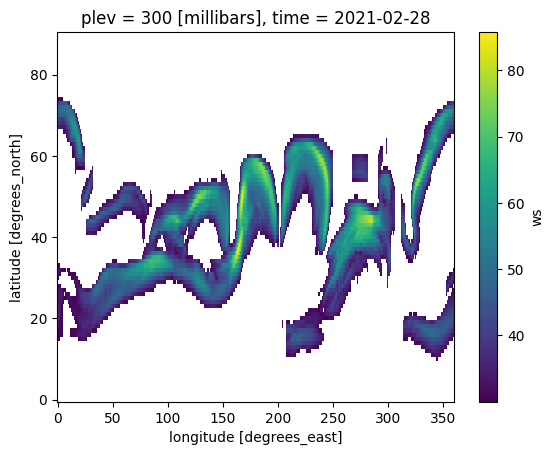

In [25]:
## all these jet regions are above 30 (boundary windspeed threshold) and have a local maxima in them
ws_slice.where(jet_region_contour_masks)['ws'].isel(plev=2).plot()

### Step 4. refine jet regions, so only left, right, above and below of jet core
The jet regions returned by the original method only check for the exceedance of a threshold directly above, below, left and right a local maxima. We replicate and refine the contour regions below to match this.

In [26]:
def refine_jet_region_to_leftright_and_abovebelow(array, x, y):
    """
    This method will remove all values not left, right, above or below the input 
    x, y coordinates in a 2-D array.
    
    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011
    
    Parameters
    ----------
    array : np.array
        A 2-D array with numeric values relating to the jet region (i.e. dtypes float or int)
    x : int
        x-coordinate of a local maxima to subset jet region by
    y: int
        y-coordinate of a local maxima to subset input array by
        
    Returns
    ----------
    refined_array : np.array
        New 2-D array with values only around x and y coordinates

    """
    rows, cols = array.shape
    refined_array = np.zeros_like(array)
    
    if 0 <= x < rows and 0 <= y < cols and array[x, y] != 0:
        # Refine the current cluster
        refined_array[x, y] = array[x, y]
        left_col = y - 1
        while left_col >= 0 and array[x, left_col] != 0:
            refined_array[x, left_col] = array[x, left_col]
            left_col -= 1
        
        right_col = y + 1
        while right_col < cols and array[x, right_col] != 0:
            refined_array[x, right_col] = array[x, right_col]
            right_col += 1
        
        up_row = x - 1
        while up_row >= 0 and array[up_row, y] != 0:
            refined_array[up_row, y] = array[up_row, y]
            up_row -= 1
        
        down_row = x + 1
        while down_row < rows and array[down_row, y] != 0:
            refined_array[down_row, y] = array[down_row, y]
            down_row += 1
    
    return refined_array

In [27]:
%%time
for ind, lon in enumerate(ws_slice.lon):
    jet_region_contour_mask_one_lon = jet_region_contour_masks[::,::,ind]
    jet_region_mask = np.zeros_like(jet_region_contour_mask_one_lon)
    
    current_local_maximas = local_maximas_dict[float(lon)]
    for local_maxima in current_local_maximas:
        refined_result = refine_jet_region_to_leftright_and_abovebelow(jet_region_contour_mask_one_lon, local_maxima[0], local_maxima[1])
        jet_region_mask += refined_result
    
    # Make the numpy matrix to stack onto using first longitude ws_contour mask
    if ind == 0:
        jet_region_masks = jet_region_mask
        continue
    jet_region_masks = np.dstack([jet_region_masks, jet_region_mask])

CPU times: user 98.4 ms, sys: 3.76 ms, total: 102 ms
Wall time: 100 ms


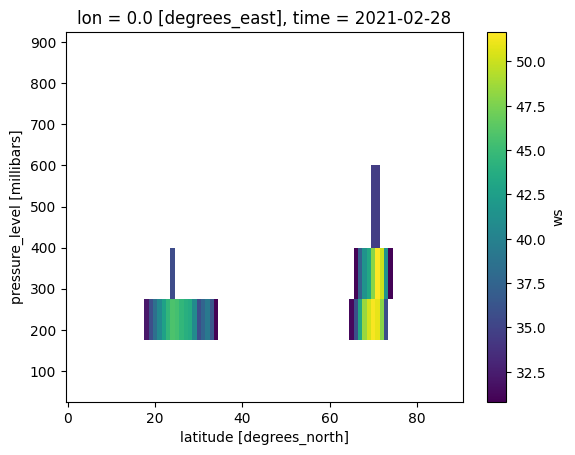

In [28]:
ws_slice.where(jet_region_masks)['ws'].isel(lon=0).plot()

Text(0.5, 1.0, 'contour mask, before refinement')

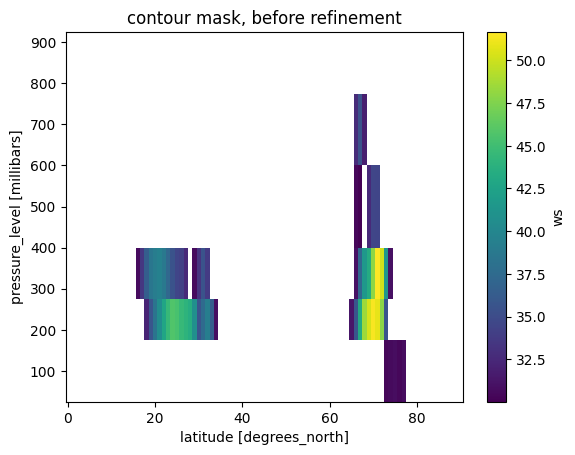

In [29]:
ws_slice.where(jet_region_contour_masks).isel(lon=0)['ws'].plot()
plt.title('contour mask, before refinement')

##### assign these variables to original dataset

In [30]:
ws_slice['jet_region_mask'] = (('plev', 'lat', 'lon'), np.clip(jet_region_masks, 0, 1))
ws_slice['jet_region_above_ws_threshold_mask'] = (('plev', 'lat', 'lon'), jet_region_contour_masks)

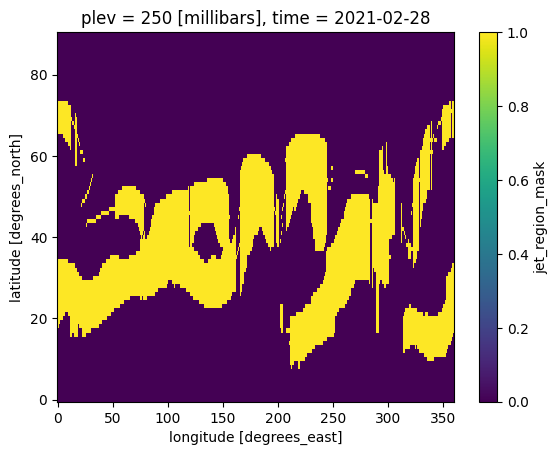

In [31]:
ws_slice['jet_region_mask'].isel(plev=1).plot()

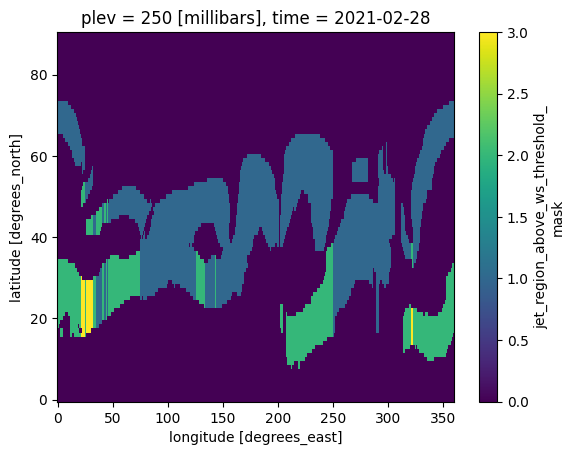

In [32]:
ws_slice['jet_region_above_ws_threshold_mask'].isel(plev=1).plot()

In [33]:
## drop unwanted 
if 'potential_jet_regions' in ws_slice:
    ws_slice = ws_slice.drop('potential_jet_regions')

### Step 5. Run checks on the jet cores to refine them based on two criterea
1. Cores are more than 15 degrees of latitude apart (see variable 'jet_core_lat_distance')  

If they are not, a further check is applied:

2. Windspeed does not drop below 25 m/s in a straight line between two cores (see variable 'ws_drop_threshold')

##### to verify
Here we use 'get_values_along_a_line_between_two_coordinates' to interpolate the values between two points in a matrix. Need to check if this is appropriate for the method.

In [34]:
## global variables
jet_core_lat_distance = 15
ws_drop_threshold = 25

In [35]:
def get_values_along_a_line_between_two_coordinates(data, start_point, end_point):
    """
    Get all values along a shortest path between two coordinates in a 2-D numpy array.
    
    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    arr : np.array
        A 2-D array with numeric values (i.e. dtypes float or int)
        
    Returns
    ----------
    local_maxima : np.array
        A 2-D array with values relating to the index of the local maximas
        
    Examples
    ----------
    .. code-block:: python
    
        import numpy as np
        
        # Example array
        data = np.array([
            [1, 2, 3, 4, 5],
            [2, 3, 4, 5, 4],
            [3, 4, 5, 6, 7],
            [4, 5, 6, 7, 6],
            [5, 6, 7, 8, 9]
        ])

        local_maxima_indices = find_local_maxima(data)

        for i, j in local_maxima_indices:
            print(f"Local maximum at ({i}, {j}): {data[i, j]}")
            
    """
    # Calculate the differences in coordinates
    dx = end_point[1] - start_point[1]
    dy = end_point[0] - start_point[0]

    # Calculate the number of steps required for the line
    num_steps = max(abs(dx), abs(dy))

    # Calculate the step sizes for each coordinate
    x_step = dx / num_steps
    y_step = dy / num_steps

    # Initialize lists to store the coordinates along the path
    path_coordinates = []
    for step in range(num_steps + 1):
        row = int(round(start_point[0] + step * y_step))
        col = int(round(start_point[1] + step * x_step))
        path_coordinates.append((row, col))

    # Extract values along the path
    values_along_path = [float(data[row, col]) for row, col in path_coordinates]

    return values_along_path


def has_ws_drop_between_cores(ws_between_cores, ws_drop_threshold):
    """
    Will check for a windspeed drop of a given threshold between cores
    
    Parameters
    ----------
    ws_between_cores : np.array
        A 1-D array with windspeed between two cores as determined by 'get_values_along_a_line_between_two_coordinates'
    ws_drop_threshold : int or float
        Windspeed threshold to check
        
    Returns
    ----------
    out : boolean
        True if windspeeds input have a drop greater than 'ws_drop_threshold'

    """
    if any(ws_between_cores[0] - np.array(ws_between_cores) > ws_drop_threshold):
        return True
    elif any(ws_between_cores[-1] - np.array(ws_between_cores) > ws_drop_threshold):
        return True
    else:
        return False

In [36]:
%%time
jet_core_masks = np.copy(initial_jet_core_masks)
for lon_ind, lon in enumerate(ws_slice.lon):
    initial_jet_core_masks_one_lon = initial_jet_core_masks[:,:,lon_ind]
    jet_region_contour_one_lon = ws_slice['jet_region_above_ws_threshold_mask'].sel(lon=lon)
    ws_one_lon = ws_slice['ws'].sel(lon=lon)
    current_local_maximas = local_maximas_dict[float(lon)]
    
    core_and_location = []
    for core_ind, local_maxima in enumerate(current_local_maximas):
        region_within = jet_region_contour_one_lon[local_maxima[0], local_maxima[1]] # this is the region contour that the jet core is found within
        core_and_location.append([core_ind, float(region_within)])
    core_and_location = np.array(core_and_location)
    
    if len(core_and_location) == 0:
        # no cores found
        continue
        
    region_ind, num_cores_in_region = np.unique(core_and_location[::,1], return_counts=True)
    multi_core_regions = region_ind[num_cores_in_region > 1]

    for multi_core_region in multi_core_regions:
        # get all the local maxima within regions of multi cores
        local_maxima_inds = core_and_location[::,0][core_and_location[::,1] == multi_core_region]
        
        # Check 1. Test if cores are more than 15 degrees away
        previous_lat = None
        for local_maxima_ind in local_maxima_inds:
            local_maxima = current_local_maximas[int(local_maxima_ind)]
            if not previous_lat:
                # set previous latitude to check for latitude distance in next
                previous_lat = local_maxima[1]
            else:
                current_lat = local_maxima[1]
                if abs(ws_slice['lat'][previous_lat] -  ws_slice['lat'][current_lat]) > jet_core_lat_distance:
                    previous_lat = current_lat
                    continue

        # Check 2. Test if cores have ws drop between them
        multi_core_region_ws = ws_one_lon.where(jet_region_contour_one_lon == multi_core_region)
        
        for multi_core_region in multi_core_regions:
            # get all the local maxima within regions of multi cores
            local_maxima_inds = core_and_location[::,0][core_and_location[::,1] == multi_core_region]
            for ind, local_maxima_ind in enumerate(local_maxima_inds):
                current_local_maxima = current_local_maximas[int(local_maxima_ind)]
                if ind == 0:
                    previous_local_maxima = current_local_maxima
                    continue
                windspeeds_between_cores = get_values_along_a_line_between_two_coordinates(\
                                                            multi_core_region_ws,\
                                                            start_point=previous_local_maxima,\
                                                            end_point=current_local_maxima)
                if not has_ws_drop_between_cores(windspeeds_between_cores, ws_drop_threshold=ws_drop_threshold):
                    # Set to 0 as the cores detected in this region are part of the same feature
                    jet_core_masks[current_local_maxima[0], current_local_maxima[1], lon_ind] = 0
            


CPU times: user 2.39 s, sys: 14 ms, total: 2.4 s
Wall time: 2.4 s


In [37]:
ws_slice['jet_core_mask'] = (('plev', 'lat', 'lon'), jet_core_masks)
if 'potential_jet_cores' in ws_slice:
    ws_slice = ws_slice.drop('potential_jet_cores')

Text(0.5, 1.0, 'before checks')

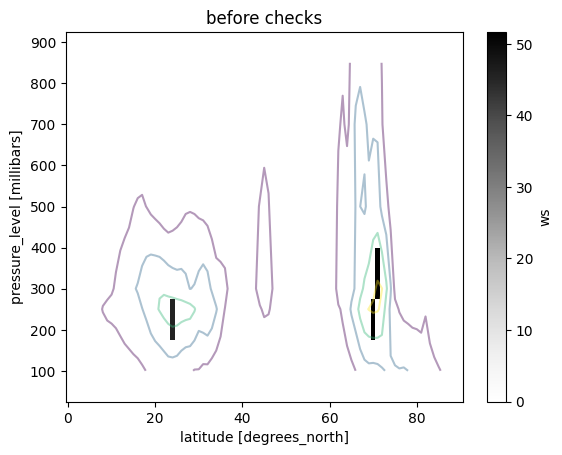

In [38]:
ws_slice['ws'].isel(lon=0).plot.contour(levels=[20, 30, 40, 50], alpha=.4)
ws_slice.where(initial_jet_core_masks)['ws'].isel(lon=0).plot(vmin=0, cmap='Greys')
plt.title('before checks')

Text(0.5, 1.0, 'after checks')

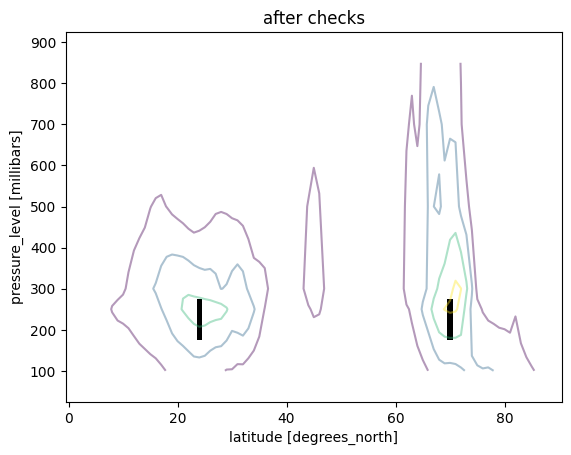

In [39]:
ws_slice['ws'].isel(lon=0).plot.contour(levels=[20, 30, 40, 50], alpha=.4)
ws_slice['jet_core_mask'].isel(lon=0).plot(vmin=0, cmap='Greys',\
                                                              add_colorbar=False)
plt.title('after checks')

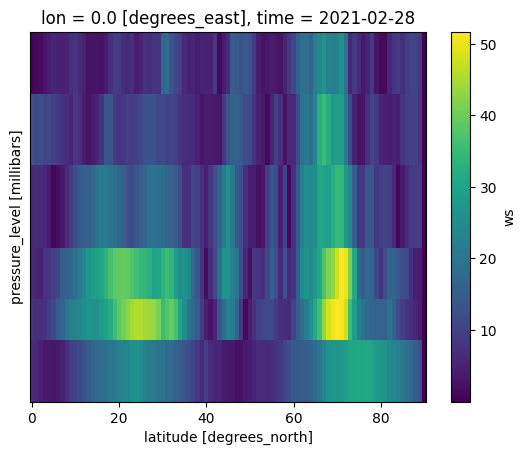

In [40]:
ws_slice['ws'].isel(lon=0).plot()
plt.plot('windspeed slice')

Text(0.5, 1.0, 'after checks with jet region shown too')

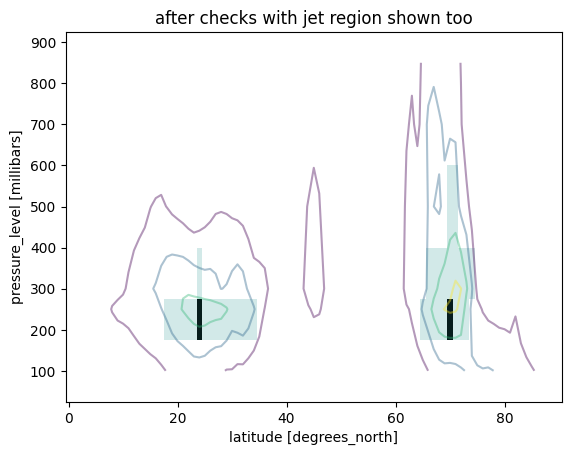

In [41]:
ws_slice['ws'].isel(lon=0).plot.contour(levels=[20, 30, 40, 50], alpha=.4)
(ws_slice['jet_core_mask']/ws_slice['jet_core_mask']).isel(lon=0).plot(vmin=0, cmap='Greys', add_colorbar=False)
(ws_slice['jet_region_mask'].isel(lon=0)/ws_slice['jet_region_mask'].isel(lon=0)).plot(alpha=.2, add_colorbar=False)
plt.title('after checks with jet region shown too')

# EXTRA STUFF (Working out and full method etc.)
## Full method

In [42]:
def manney_et_al_2011(
    data,
    jet_core_ws_threshold=40,
    jet_boundary_ws_threshold=30,
    jet_core_plev_limit=(100, 400),
    ws_drop_threshold=25,
    jet_core_lat_distance=15,
):
    r"""
    This method detects jet cores and defines a boundary region beside those cores based on two windspeed thresholds.
    Two additional checks are applied after initial detection of cores to check whether cores within the same windspeed region
    are part of the same feature (default is 30 m/s, see 'jet_boundary_ws_threshold').
    This is achieved by checking whether regions with multiple jet cores are more than a certain distance apart
    (default is 15 degrees, see 'jet_core_lat_distance') and the windspeed between two cores does not drop below a threshold
    (default is 25 m/s, see 'ws_drop_threshold')

    This method returns four outputs
        1. 'jet_core_mask' -- Regions within each latitude/altitude that are local maxima have windspeeds above the 'jet_core_ws_threshold'
        2. 'jet_region_mask' -- Regions above, below, left and right of the jet core with windspeed above the 'jet_boundary_ws_threshold'
        3. 'jet_region_contour_mask' -- All contigious regions of windspeeds emcompassing a jet core above the 'jet_boundary_ws_threshold' (i.e. not just above, below, left and right)
        4. 'ws' -- Wind speed calculated from 'ua', 'va' inputs.

    This method was originally introduce in Manney et al. (2011) (https://doi.org/10.5194/acp-11-6115-2011),
    and is described in Section 3.1 of that study. This method is also known as JETPAC, and available in its
    original form from NASA JPL.

    There is an update to this method introduced in Manney & Hegglin 2018 to include physically-based method to extract the
    subtropical jet is identified (and thus distinguished from polar jets).


    Parameters
    ----------
    data : xarray.Dataset
        Data which should containing the variables: 'ua' and 'va', and the coordinates: 'lon', 'lat', 'plev' and 'time'.
    jet_core_ws_threshold : int or float
        Threshold used for jet-stream core point (default=40 m/s)
    jet_boundary_ws_threshold : int or float
        Threshold for jet-stream boundary point (default=30 m/s)
    jet_core_plev_limit: tuple or array
        Sequence of two values relating to the pressure level limit of the jet cores (default: (100, 400))
    ws_drop_threshold : int or float
        Threshold for drop in windspeed along the line between cores (default: 25 m/s)
    jet_core_lat_distance : int or float
        Threshold for maximum distance between cores to be counted the same (default: 15 degrees)

    Returns
    ----------
    output : xarray.Dataset
        Data containing the variable 'jet-core_id' (ID number relates to each unique core)

    Notes
    -----
    The implementation of this method varies slightly from the original, in that this method will return
    variables that have 0, 1+ values, so that the user can use these as a mask on other variables such as windspeed
    (see 'Examples' for demonstration of how to use the mask).
    Also, 'jet_region_above_ws_threshold_mask' is provided here as a alternative to using a contour to check which regions
    encompass jet cores.

    Examples
    --------
    .. code-block:: python

        import jsmetrics
        import xarray as xr

        # Load in dataset with u and v components:
        uv_data = xr.open_dataset('path_to_uv_data')

        # Subset dataset to range appropriate for original methodology (100-1000 hPa)):
        uv_sub = uv_data.sel(plev=slice(100, 1900))

        # Run algorithm:
        manney_outputs = jsmetrics.jet_core_algorithms.manney_et_al_2011(uv_sub, ws_core_threshold=40, ws_boundary_threshold=30, jet_core_plev_limit=(100, 400))

        # Use the jet core mask to extract the jet windspeeds
        manney_jet_ws = manney_outputs.where(manney_outputs['jet_core_mask'])['ws']

    """
    if "plev" not in data.dims:
        data = data.expand_dims("plev")

    # Step 1. Calculate wind speed from ua and va components.
    data["ws"] = windspeed_utils.get_resultant_wind(data["ua"], data["va"])

    # Step 2. Run Algorithm
    if "time" not in data.coords:
        raise KeyError("Please provide a time coordinate for data to run this metric")
    if data["time"].size == 1:
        if "time" in data.dims:
            data = data.squeeze("time")
        output = (
            run_jet_core_and_region_algorithm_on_one_day(
                data,
                jet_core_ws_threshold,
                jet_boundary_ws_threshold,
                jet_core_plev_limit,
                ws_drop_threshold,
                jet_core_lat_distance,
            )
        )
    else:
        output = data.groupby("time").map(
            run_jet_core_and_region_algorithm_on_one_day,
            (
                jet_core_ws_threshold,
                jet_boundary_ws_threshold,
                jet_core_plev_limit,
                ws_drop_threshold,
                jet_core_lat_distance,
            ),
        )
    return output

In [43]:
def run_checks_on_jet_cores_and_return_jet_cores(row, initial_jet_core_masks, local_maximas_dict, jet_core_lat_distance, ws_drop_threshold):
    """
    This method runs two checks on the jet cores to check whether there are regions with multiple jet cores.
    Firstly, it checks whether regions with multiple jet cores are more than a certain distance apart
    (default is 15 degrees, see 'jet_core_lat_distance'), and hence seperate cores.
    Secondly, it will check whether the windspeed between two cores drops below a threshold
    (default is 25 m/s, see 'ws_drop_threshold'), if so it will remove the latter core.
    
    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    row : xarray.Dataset
        Data of single time unit containing the variables: 'jet_region_contour_mask', and the coordinates: 'lon', 'lat', 'plev'
    initial_jet_core_masks : 
        Initial mask of jet cores to check. 
    ws_drop_threshold : int or float
        Threshold for drop in windspeed along the line between cores (default: 25 m/s)
    jet_core_lat_distance : int or float
        Threshold for maximum distance between cores to be counted the same (default: 15 degrees)
    
    Returns
    ----------
    jet_core_masks : numpy.array
        Final jet cores mask of shape of 'initial_jet_core_masks'.
    
    """
    jet_core_masks = np.copy(initial_jet_core_masks)
    for lon_ind, lon in enumerate(row.lon):
        initial_jet_core_masks_one_lon = initial_jet_core_masks[:,:,lon_ind]
        jet_region_contour_one_lon = row['jet_region_contour_mask'].sel(lon=lon)
        ws_one_lon = row['ws'].sel(lon=lon)
        current_local_maximas = local_maximas_dict[float(lon)]

        core_and_location = []
        for core_ind, local_maxima in enumerate(current_local_maximas):
            region_within = jet_region_contour_one_lon[local_maxima[0], local_maxima[1]] # this is the region contour that the jet core is found within
            core_and_location.append([core_ind, float(region_within)])
        core_and_location = np.array(core_and_location)

        if len(core_and_location) == 0:
            # no cores found
            continue

        region_ind, num_cores_in_region = np.unique(core_and_location[::,1], return_counts=True)
        multi_core_regions = region_ind[num_cores_in_region > 1]

        if len(multi_core_regions) == 0:
            # no multi-core regions found
            continue
            
        for multi_core_region in multi_core_regions:
            # get all the local maxima within regions of multi cores
            local_maxima_inds = core_and_location[::,0][core_and_location[::,1] == multi_core_region]

            # Check 1. Test if cores are more than 15 degrees away
            previous_lat = None
            for local_maxima_ind in local_maxima_inds:
                local_maxima = current_local_maximas[int(local_maxima_ind)]
                if not previous_lat:
                    # set previous latitude to check for latitude distance in next
                    previous_lat = local_maxima[1]
                else:
                    current_lat = local_maxima[1]
                    if abs(row['lat'][previous_lat] -  row['lat'][current_lat]) > jet_core_lat_distance:
                        previous_lat = current_lat
                        continue

            # Check 2. Test if cores have ws drop between them
            multi_core_region_ws = ws_one_lon.where(jet_region_contour_one_lon == multi_core_region)

            for multi_core_region in multi_core_regions:
                # get all the local maxima within regions of multi cores
                local_maxima_inds = core_and_location[::,0][core_and_location[::,1] == multi_core_region]
                for ind, local_maxima_ind in enumerate(local_maxima_inds):
                    current_local_maxima = current_local_maximas[int(local_maxima_ind)]
                    if ind == 0:
                        previous_local_maxima = current_local_maxima
                        continue
                    windspeeds_between_cores = get_values_along_a_line_between_two_coordinates(\
                                                                multi_core_region_ws,\
                                                                start_point=previous_local_maxima,\
                                                                end_point=current_local_maxima)
                    if not has_ws_drop_between_cores(windspeeds_between_cores, ws_drop_threshold=ws_drop_threshold):
                        # Set to 0 as the cores detected in this region are part of the same feature
                        jet_core_masks[current_local_maxima[0], current_local_maxima[1], lon_ind] = 0
    return jet_core_masks

In [44]:
def run_jet_core_and_region_algorithm_on_one_day(
    row,
    jet_core_ws_threshold,
    jet_boundary_ws_threshold,
    jet_core_plev_limit,
    ws_drop_threshold,
    jet_core_lat_distance,
):
    r"""
    This method detects jet cores and defines a boundary region beside those cores based on two windspeed thresholds.
    Two additional checks are applied after initial detection of cores to check whether cores within the same windspeed region
    are part of the same feature (see 'jet_boundary_ws_threshold'). This is achieved by checking whether regions with multiple
    jet cores are more than a certain distance apart (see 'jet_core_lat_distance') and the windspeed between two cores does
    not drop below a threshold (see 'ws_drop_threshold'). This function runs this method on a single time unit.

    This method returns four outputs
        1. 'jet_core_mask' -- Regions within each latitude/altitude that are local maxima have windspeeds above the 'jet_core_ws_threshold'
        2. 'jet_region_mask' -- Regions above, below, left and right of the jet core with windspeed above the 'jet_boundary_ws_threshold'
        3. 'jet_region_contour_mask' -- All contigious regions of windspeeds emcompassing a jet core above the 'jet_boundary_ws_threshold' (i.e. not just above, below, left and right)
        4. 'ws' -- Wind speed calculated from 'ua', 'va' inputs.

    Component of method of algorithm originally introduced in Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011

    Parameters
    ----------
    row : xarray.Dataset
        Data of single time unit containing the variables: 'ua' and 'va', and the coordinates: 'lon', 'lat', 'plev'
    jet_core_ws_threshold : int or float
        Threshold used for jet-stream core point (default=40 m/s)
    jet_boundary_ws_threshold : int or float
        Threshold for jet-stream boundary point (default=30 m/s)
    jet_core_plev_limit: tuple or array
        Sequence of two values relating to the pressure level limit of the jet cores (default: (100, 400))
    ws_drop_threshold : int or float
        Threshold for drop in windspeed along the line between cores (default: 25 m/s)
    jet_core_lat_distance : int or float
        Threshold for maximum distance between cores to be counted the same (default: 15 degrees)

    Returns
    ----------
    row : xarray.Dataset
        Data for one time unit containing four new variables (ws, jet_core_mask, jet_region_mask, jet_region_above_ws_threshold_mask)
    """
    # Step 1. Get potential cores (to later subset) using the wind speed thresholds and jet core pressure level limit. 
    row['potential_jet_cores'] = row['ws'].where(lambda val: (val>=jet_core_ws_threshold) & (val.plev >= min(jet_core_plev_limit)) & (val.plev <= max(jet_core_plev_limit)), 0)
    row['potential_jet_regions'] = row['ws'].where(lambda val: val>=jet_boundary_ws_threshold, 0)
    
    # Step 2. Get local maximas at each longitude
    local_maximas_dict = {}
    for ind, lon in enumerate(row['lon']):
        pot_core_one_lon = row['potential_jet_cores'].sel(lon=lon)
        local_maximas = find_local_maxima_in_2d_dataarray(pot_core_one_lon)
        local_maximas_dict[float(lon)] = local_maximas
    
    # Step 3. Loop through the local maximas and make an mask of initial jet cores (not official as some may be in same region, see check in Step X)  
    mask_shape = row['ws'].isel(lon=0).shape
    for ind, local_maximas in enumerate(local_maximas_dict.values()):
        initial_jet_core_mask = create_mask_using_local_maximas(mask_shape=mask_shape, local_maximas=local_maximas)
        if ind == 0:
            initial_jet_core_masks = initial_jet_core_mask
            continue
        initial_jet_core_masks = np.dstack([initial_jet_core_masks, initial_jet_core_mask])
    
    # Step 4. Loop through contigious regions (here known as jet region contours) and check if a jet core is within them 
    for ind, lon in enumerate(row.lon):
        jet_region_contour_mask = get_jet_region_contour_mask(row['potential_jet_regions'].sel(lon=lon),\
                                                              local_maximas_dict[float(lon)])
        if ind == 0:
            jet_region_contour_masks = jet_region_contour_mask
            continue
        jet_region_contour_masks = np.dstack([jet_region_contour_masks, jet_region_contour_mask])
    
    # Step 5. Get the jet region around each local maxima only including above, below, left and right of maxima.
    for ind, lon in enumerate(row.lon):
        jet_region_contour_mask_one_lon = jet_region_contour_masks[::,::,ind]
        jet_region_mask = np.zeros_like(jet_region_contour_mask_one_lon) # create empty mask

        current_local_maximas = local_maximas_dict[float(lon)]
        for local_maxima in current_local_maximas:
            refined_result = refine_jet_region_to_leftright_and_abovebelow(jet_region_contour_mask_one_lon, local_maxima[0], local_maxima[1])
            jet_region_mask += refined_result
        if ind == 0:
            jet_region_masks = jet_region_mask
            continue
        jet_region_masks = np.dstack([jet_region_masks, jet_region_mask])
    
    # Step 6. Remove old jet regions and define two outputs (jet_region, region_above_ws_threshold)
    row = row.drop('potential_jet_regions')
    row['jet_region_mask'] = (('plev', 'lat', 'lon'), np.clip(jet_region_masks, 0, 1))
    row['jet_region_contour_mask'] = (('plev', 'lat', 'lon'), jet_region_contour_masks)
    
    # Step 7. Run checks on jet cores, to check if they are part of the same jet feature
    jet_core_masks = run_checks_on_jet_cores_and_return_jet_cores(row, initial_jet_core_masks, local_maximas_dict, jet_core_lat_distance, ws_drop_threshold)
    
    # Step 8. Remove old and add actual jet core mask
    row = row.drop('potential_jet_cores')
    row['jet_core_mask'] = (('plev', 'lat', 'lon'), jet_core_masks)
    return row


In [45]:
%%time
out = manney_et_al_2011(uava)

CPU times: user 3min 29s, sys: 515 ms, total: 3min 29s
Wall time: 3min 29s


In [46]:
out['jet_core_mask'].astype(float).max()

<xarray.DataArray 'jet_core_mask' ()>
array(1.)

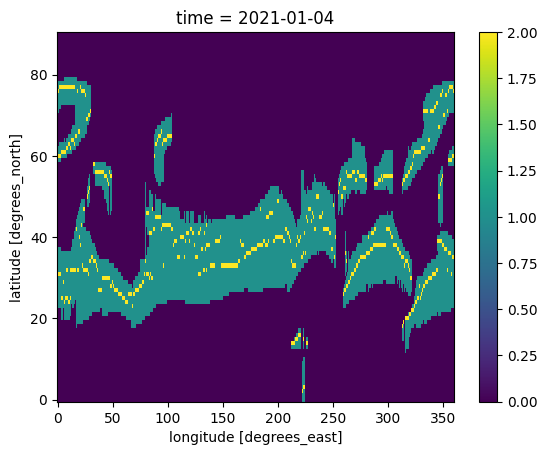

In [52]:
(out['jet_region_mask'].isel(time=3).max('plev') + out['jet_core_mask'].isel(time=3).max('plev')).plot()

## alternative with diagonals checked for jet cores

In [ ]:
def find_local_maxima_in_2d_dataarray_corneredge_check(arr):
    """
    CORNER AND EDGE CHECK
    Find indices of local maximas within a 2-D array.
    Should return two values which relate to the position of local maximas (if any).

    Component of method  from Manney et al. (2011) https://doi.org/10.5194/acp-11-6115-2011
    
    Parameters
    ----------
    arr : xr.DataArray
        A 2-D array with numeric values (i.e. dtypes float or int)
        
    Returns
    ----------
    local_maxima : xr.DataArray
        A 1-D array with values relating to the index of the local maximas
        
    Examples
    ----------
    .. code-block:: python
    
        import numpy as np
        import xarray as xr
        
        # Example array
        data = np.array([
            [1, 2, 3, 4, 5],
            [2, 3, 4, 5, 4],
            [3, 4, 5, 6, 7],
            [4, 5, 6, 7, 6],
            [5, 6, 7, 8, 9]
        ])
        
        # Convert NumPy array to xarray DataArray
        data_array = xr.DataArray(data)

        local_maxima_indices = find_local_maxima_in_2d_dataarray(data_array)

        for i, j in local_maxima_indices:
            print(f"Local maximum at ({i}, {j}): {data_array[i, j]}")
            
    """
    local_maxima = []
    
    # # POTENTIAL NEW ALTERNATIVE Add padding to array to allow edges to be picked up
    # arr = add_pad_to_array(arr)
    
    # Calculate neighbors for all interior points
    neighbors = np.stack([
        arr[:-2, 1:-1],  # Above
        arr[2:, 1:-1],   # Below
        arr[1:-1, :-2],  # Left
        arr[1:-1, 2:]    # Right
    ], axis=-1)
    
    # Find local maximas
    interior_maxima = (arr[1:-1, 1:-1] > np.max(neighbors, axis=-1))
    interior_indices = np.transpose(np.where(interior_maxima))
    local_maxima.extend([(i+1, j+1) for i, j in interior_indices])
    
    # Check edges and corners
    top_maxima = np.where(arr[1, 1:-1] > np.maximum(arr[0, 1:-1], arr[2, 1:-1]))[0]
    local_maxima.extend([(0, j+1) for j in top_maxima])
    
    bottom_maxima = np.where(arr[-2, 1:-1] > np.maximum(arr[-1, 1:-1], arr[-3, 1:-1]))[0]
    local_maxima.extend([(arr.shape[0] - 1, j+1) for j in bottom_maxima])
    
    left_maxima = np.where(arr[1:-1, 1] > np.maximum(arr[1:-1, 0], arr[1:-1, 2]))[0]
    local_maxima.extend([(i+1, 0) for i in left_maxima])
    
    right_maxima = np.where(arr[1:-1, -2] > np.maximum(arr[1:-1, -1], arr[1:-1, -3]))[0]
    local_maxima.extend([(i+1, arr.shape[1] - 1) for i in right_maxima])
    
    # Check corners
    if arr[0, 0] > np.maximum(arr[1, 0], arr[0, 1]):
        local_maxima.append((0, 0))
    if arr[0, -1] > np.maximum(arr[1, -1], arr[0, -2]):
        local_maxima.append((0, arr.shape[1] - 1))
    if arr[-1, 0] > np.maximum(arr[-2, 0], arr[-1, 1]):
        local_maxima.append((arr.shape[0] - 1, 0))
    if arr[-1, -1] > np.maximum(arr[-2, -1], arr[-1, -2]):
        local_maxima.append((arr.shape[0] - 1, arr.shape[1] - 1))
    
    return np.array(local_maxima)